**Vector Error Correction Model Configuration & Analysis**

Error correction model (ECM)is important in time-series analysis to better understand long-run dynamics. ECM can be derived from auto-regressive distributed lag model as long as there is a cointegration relationship between variables. In that context, each equation in the vector auto regressive (VAR) model is an autoregressive distributed lag model; therefore, it can be considered that the vector error correction model (VECM) is a VAR model with cointegration constraints.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fx-min-data/April_data_6series.csv


In [2]:
import datetime, pickle, copy, warnings
from pandas import DataFrame, merge, concat
import glob
from matplotlib import pyplot as plt
plt.style.use('dark_background')

In [3]:
df = pd.read_csv('/kaggle/input/fx-min-data/April_data_6series.csv')
df.sample(5)

,Unnamed: 0,timestamp,es,eurusd,gbpusd,gc,nq,usdjpy
26176,26176,2020-05-27 16:12:00,2994.625,1098025.0,1224085.0,1698.85,9354.875,107748000.0
21078,21078,2020-05-22 00:15:00,2947.625,1095010.0,1222430.0,1727.25,9397.375,107619500.0
28752,28752,2020-05-29 11:08:00,3031.125,1114065.0,1234030.0,1726.50,9441.125,107233500.0
13933,13933,2020-05-14 22:11:00,2846.875,1080650.0,1222620.0,1738.25,9087.000,107233500.0
23041,23041,2020-05-25 11:57:00,2980.375,1090975.0,1218405.0,1727.05,9508.000,107685000.0


In [4]:
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
df = df.set_index('timestamp')
df.index = pd.to_datetime(df.index)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29345 entries, 2020-05-01 00:00:00 to 2020-05-29 21:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   es      29345 non-null  float64
 1   eurusd  29345 non-null  float64
 2   gbpusd  29345 non-null  float64
 3   gc      29345 non-null  float64
 4   nq      29345 non-null  float64
 5   usdjpy  29345 non-null  float64
dtypes: float64(6)
memory usage: 1.6 MB


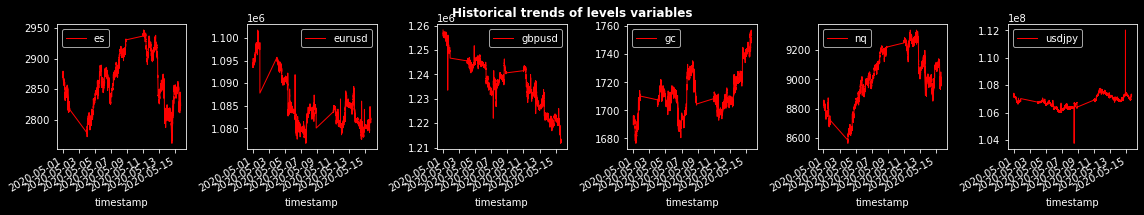

In [5]:
X = df[:15000] # subset of data
plt.style.use('dark_background')
def plot_vars(train, levels, color, leveltype):
    
    """
    Displays historical trends of variables
    And see if it's sensible to just select levels instead of differences
    """
    fig, ax = plt.subplots(1, 6, figsize=(16,3), sharex=True)
    for col, i in dict(zip(levels, list(range(6)))).items():
        X[col].plot(ax=ax[i], legend=True, linewidth=1.0, color=color, sharex=True)     
    
    fig.suptitle(f"Historical trends of {leveltype} variables", 
                 fontsize=12, fontweight="bold")
    
plot_vars(X.values, levels = X.columns, color="red", leveltype="levels")
plt.tight_layout()

In [6]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")
        
# ADF Test on each column
for name, column in X.iteritems():
    adfuller_test(column, name=column.name)
    print()

    Augmented Dickey-Fuller Test on "es" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.8089
 No. Lags Chosen       = 29
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.376. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.

    Augmented Dickey-Fuller Test on "eurusd" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.9487
 No. Lags Chosen       = 8
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.3095. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.

    Augmented Dickey-Fuller Test on "gbpusd" 
    -----------------------------------------------
 Null Hypothesis: Data has unit ro

In [7]:
from statsmodels.tsa.stattools import kpss
def kpss_test(x, h0_type='c'):
    indices = ['Test Statistic', 'p-value', '# of Lags']
    kpss_test = kpss(x, regression=h0_type, nlags ='auto')
    results = pd.Series(kpss_test[0:3], index=indices)
    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value
        return results
print('KPSS-EURUSD:')
print(kpss_test(X.eurusd))
print('___________________')
print('KPSS-GBPUSD:')
print(kpss_test(X.gbpusd))
print('___________________')
print('KPSS-USDJPY:')
print(kpss_test(X.usdjpy))
print('___________________')
print('KPSS-GC:')
print(kpss_test(X.gc))
print('___________________')
print('KPSS-NQ:')
print(kpss_test(X.nq))
print('___________________')
print('KPSS-ES:')
print(kpss_test(X.es))

KPSS-EURUSD:
Test Statistic          10.179718
p-value                  0.010000
# of Lags               73.000000
Critical Value (10%)     0.347000
dtype: float64
___________________
KPSS-GBPUSD:
Test Statistic          17.094998
p-value                  0.010000
# of Lags               73.000000
Critical Value (10%)     0.347000
dtype: float64
___________________
KPSS-USDJPY:
Test Statistic           7.517454
p-value                  0.010000
# of Lags               73.000000
Critical Value (10%)     0.347000
dtype: float64
___________________
KPSS-GC:
Test Statistic           7.2062
p-value                  0.0100
# of Lags               73.0000
Critical Value (10%)     0.3470
dtype: float64
___________________
KPSS-NQ:
Test Statistic          10.65104
p-value                  0.01000
# of Lags               73.00000
Critical Value (10%)     0.34700
dtype: float64
___________________
KPSS-ES:
Test Statistic           3.499804
p-value                  0.010000
# of Lags              

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than 

In [8]:
from scipy import stats

stat,p = stats.normaltest(X.eurusd)
print('Statistics=%.3f, p=%.3f' % (stat,p))
alpha = 0.05
if p > alpha:
    print('EURUSD Data looks Gaussian (fail to reject H0)')
else:
    print('EURUSD Data do not look Gaussian (reject H0)')
print('______________')
stat,p = stats.normaltest(X.gbpusd)
print('Statistics=%.3f, p=%.3f' % (stat,p))
alpha = 0.05
if p > alpha:
    print('GBPUSD Data looks Gaussian (fail to reject H0)')
else:
    print('GBPUSD Data do not look Gaussian (reject H0)')
print('______________')
stat,p = stats.normaltest(X.usdjpy)
print('Statistics=%.3f, p=%.3f' % (stat,p))
alpha = 0.05
if p > alpha:
    print('USDJPY Data looks Gaussian (fail to reject H0)')
else:
    print('USDJPY Data do not look Gaussian (reject H0)')
print('______________')
stat,p = stats.normaltest(X.es)
print('Statistics=%.3f, p=%.3f' % (stat,p))
alpha = 0.05
if p > alpha:
    print('ES Data looks Gaussian (fail to reject H0)')
else:
    print('ES Data do not look Gaussian (reject H0)')
print('______________')
stat,p = stats.normaltest(X.nq)
print('Statistics=%.3f, p=%.3f' % (stat,p))
alpha = 0.05
if p > alpha:
    print('NQ Data looks Gaussian (fail to reject H0)')
else:
    print('NQ Data do not look Gaussian (reject H0)')
print('______________')
stat,p = stats.normaltest(X.gc)
print('Statistics=%.3f, p=%.3f' % (stat,p))
alpha = 0.05
if p > alpha:
    print('GC Data looks Gaussian (fail to reject H0)')
else:
    print('GC Data do not look Gaussian (reject H0)')
print('______________')
print('EURUSD: Kurtosis of normal distribution: {}'. format(stats.kurtosis(X.eurusd)))
print('EURUSD: Skewness of normal distribution: {}'. format(stats.skew(X.eurusd)))
print('************')
print('GBPUSD: Kurtosis of normal distribution: {}'. format(stats.kurtosis(X.gbpusd)))
print('GBPUSD: Skewness of normal distribution: {}'. format(stats.skew(X.gbpusd)))
print('************')
print('USDJPY: Kurtosis of normal distribution: {}'. format(stats.kurtosis(X.usdjpy)))
print('USDJPY: Skewness of normal distribution: {}'. format(stats.skew(X.usdjpy)))
print('************')
print('ES: Kurtosis of normal distribution: {}'. format(stats.kurtosis(X.es)))
print('ES: Skewness of normal distribution: {}'. format(stats.skew(df.es)))
print('************')
print('NQ: Kurtosis of normal distribution: {}'. format(stats.kurtosis(X.nq)))
print('NQ: Skewness of normal distribution: {}'. format(stats.skew(X.nq)))
print('************')
print('GC: Kurtosis of normal distribution: {}'. format(stats.kurtosis(X.gc)))
print('GC: Skewness of normal distribution: {}'. format(stats.skew(X.gc)))

Statistics=2257.662, p=0.000
EURUSD Data do not look Gaussian (reject H0)
______________
Statistics=862.816, p=0.000
GBPUSD Data do not look Gaussian (reject H0)
______________
Statistics=5045.826, p=0.000
USDJPY Data do not look Gaussian (reject H0)
______________
Statistics=1907.939, p=0.000
ES Data do not look Gaussian (reject H0)
______________
Statistics=740.956, p=0.000
NQ Data do not look Gaussian (reject H0)
______________
Statistics=605.687, p=0.000
GC Data do not look Gaussian (reject H0)
______________
EURUSD: Kurtosis of normal distribution: 0.3931852746529727
EURUSD: Skewness of normal distribution: 1.1532580192128514
************
GBPUSD: Kurtosis of normal distribution: -0.7174460654306789
GBPUSD: Skewness of normal distribution: -0.035640206114854266
************
USDJPY: Kurtosis of normal distribution: 12.507168914941829
USDJPY: Skewness of normal distribution: 1.119667710097836
************
ES: Kurtosis of normal distribution: -0.8797627798905969
ES: Skewness of normal

count     15000.00
mean    1084849.18
std        5344.95
min     1076660.00
25%     1080880.00
50%     1083670.00
75%     1085940.00
max     1101775.00
Name: eurusd, dtype: float64

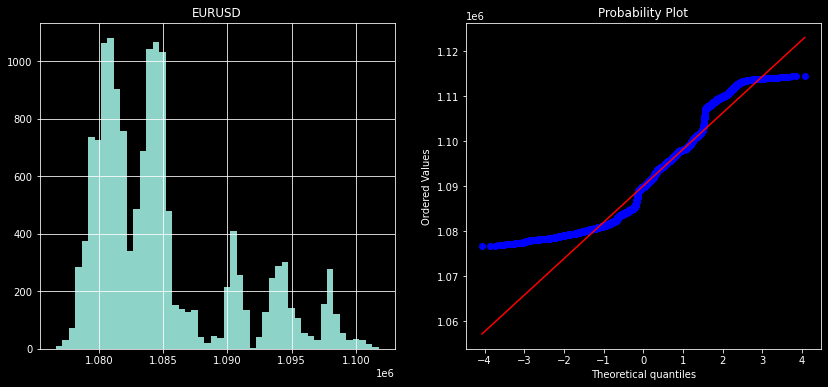

In [9]:
# visualization (EURUSD)
pd.options.display.float_format = "{:.2f}".format
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
X['eurusd'].hist(bins=50)
plt.title('EURUSD')
plt.subplot(1,2,2)
stats.probplot(df['eurusd'], plot=plt);
X['eurusd'].describe().T

count     15000.00
mean    1235693.65
std       10079.86
min     1211710.00
25%     1227800.00
50%     1236127.50
75%     1243690.00
max     1258140.00
Name: gbpusd, dtype: float64

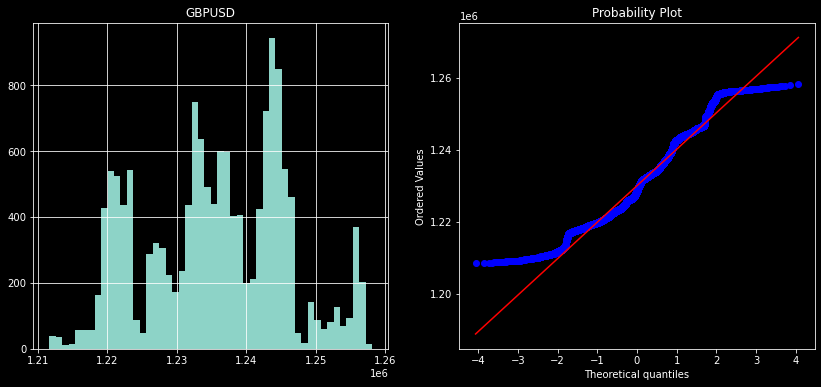

In [10]:
# visualization (GBPUSD)
pd.options.display.float_format = "{:.2f}".format
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
X['gbpusd'].hist(bins=50)
plt.title('GBPUSD')
plt.subplot(1,2,2)
stats.probplot(df['gbpusd'], plot=plt);
X['gbpusd'].describe().T

count       15000.00
mean    106842631.73
std        433442.34
min     103750000.00
25%     106512500.00
50%     106841500.00
75%     107164500.00
max     112017500.00
Name: usdjpy, dtype: float64

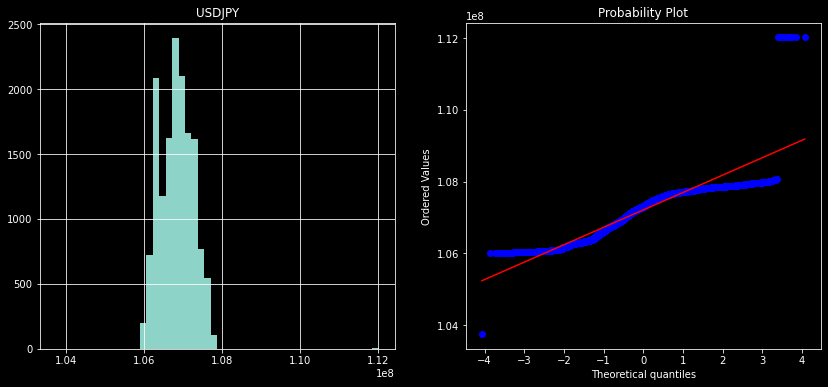

In [11]:
# visualization (USDJPY)
pd.options.display.float_format = "{:.2f}".format
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
X['usdjpy'].hist(bins=50)
plt.title('USDJPY')
plt.subplot(1,2,2)
stats.probplot(df['usdjpy'], plot=plt);
X['usdjpy'].describe().T

count   15000.00
mean     2861.23
std        40.96
min      2761.62
25%      2831.38
50%      2856.62
75%      2897.12
max      2946.38
Name: es, dtype: float64

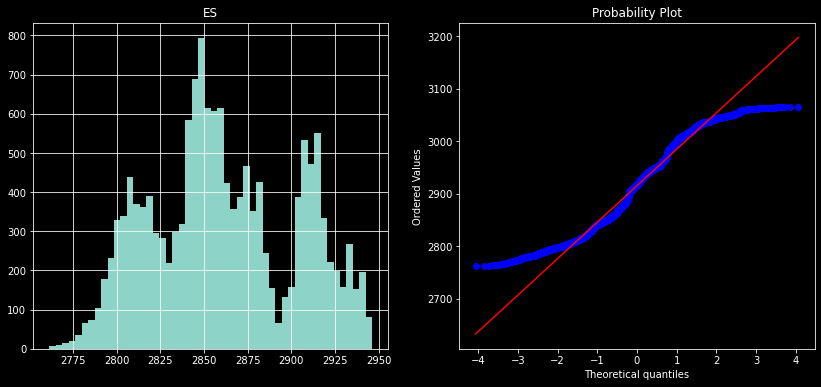

In [12]:
# visualization (ES)
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
X['es'].hist(bins=50)
plt.title('ES')
plt.subplot(1,2,2)
stats.probplot(df['es'], plot=plt);
X['es'].describe().T

count   15000.00
mean     1711.85
std        15.17
min      1676.50
25%      1703.35
50%      1709.05
75%      1721.50
max      1757.15
Name: gc, dtype: float64

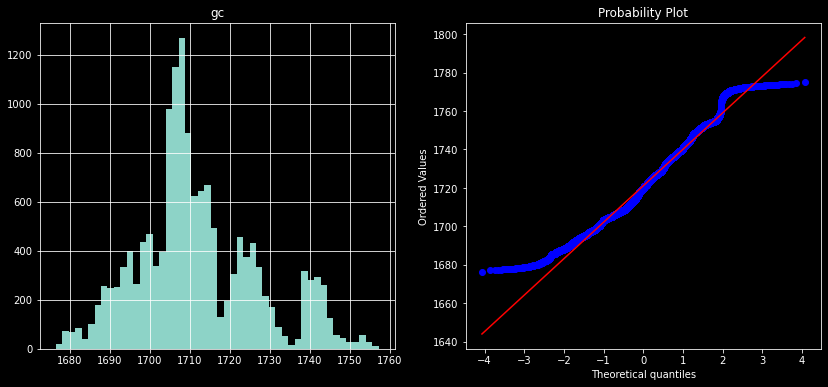

In [13]:
# visualization (GC)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
X['gc'].hist(bins=50)
plt.title('gc')
plt.subplot(1,2,2)
stats.probplot(df['gc'], plot=plt);
X['gc'].describe().T

value > 0.5 is considerred correlated, > 0.8 is highly correlated


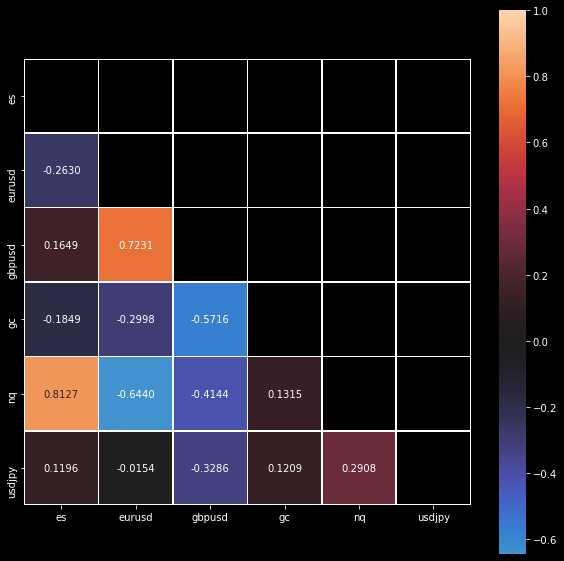

Correlation matrix:


,es,eurusd,gbpusd,gc,nq,usdjpy
es,1.00,-0.26,0.16,-0.18,0.81,0.12
eurusd,-0.26,1.00,0.72,-0.30,-0.64,-0.02
gbpusd,0.16,0.72,1.00,-0.57,-0.41,-0.33
gc,-0.18,-0.30,-0.57,1.00,0.13,0.12
nq,0.81,-0.64,-0.41,0.13,1.00,0.29
usdjpy,0.12,-0.02,-0.33,0.12,0.29,1.00


In [14]:
import seaborn as sns
# Compute the correlation matrix
corr = X.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))
# Heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt = '.4f', mask=mask, center=0, square=True, linewidths=.5)
print("value > 0.5 is considerred correlated, > 0.8 is highly correlated")
plt.show()
print('Correlation matrix:')
corr = X.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [15]:
from statsmodels.tsa.stattools import grangercausalitytests
max_lag = 6
test = 'ssr_chi2test'
def causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    X = DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in X.columns:
        for r in X.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag = max_lag, verbose = False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(max_lag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            X.loc[r, c] = min_p_value
    X.columns = [var + '-x axis' for var in variables]
    X.index = [var + '-y axis' for var in variables]
    return X
causation_matrix(X, variables = X.columns)

,es-x axis,eurusd-x axis,gbpusd-x axis,gc-x axis,nq-x axis,usdjpy-x axis
es-y axis,1.00,0.00,0.05,0.70,0.01,0.00
eurusd-y axis,0.00,1.00,0.00,0.00,0.00,0.02
gbpusd-y axis,0.00,0.00,1.00,0.00,0.00,0.03
gc-y axis,0.03,0.03,0.00,1.00,0.06,0.00
nq-y axis,0.00,0.00,0.03,0.69,1.00,0.00
usdjpy-y axis,0.06,0.17,0.00,0.10,0.00,1.00


In [16]:
from statsmodels.tsa.vector_ar.vecm import VECM, select_order
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
from statsmodels.tsa.vector_ar.vecm import CointRankResults

In [17]:
nobs = 15
train_ecm, test_ecm = X[0:-nobs], X[-nobs:]

# Check size
print(train_ecm.shape)  
print(test_ecm.shape)

(14985, 6)
(15, 6)


In [18]:
# VECM model fitting
from statsmodels.tsa.vector_ar import vecm
# pass "1min" frequency
train_ecm.index = pd.DatetimeIndex(train_ecm.index).to_period('1min')
model = vecm.select_order(train_ecm, maxlags=8)
print(model.summary())

 VECM Order Selection (* highlights the minimums)
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       45.14       45.16   4.006e+19       45.14
1       44.94       44.98   3.298e+19       44.96
2       44.87      44.93*   3.071e+19       44.89
3       44.86       44.94   3.041e+19       44.89
4       44.85       44.95   3.019e+19      44.89*
5       44.85       44.97   3.018e+19       44.89
6       44.85       44.98   3.015e+19       44.90
7       44.85       45.00   3.013e+19       44.90
8      44.85*       45.02  3.012e+19*       44.91
-------------------------------------------------


In [19]:
# Johansen co-integration
pd.options.display.float_format = "{:.2f}".format
"""definition of det_orderint:
-1 - no deterministic terms; 0 - constant term; 1 - linear trend"""
pd.options.display.float_format = "{:.2f}".format
model = coint_johansen(endog = train_ecm, det_order = 1, k_ar_diff = 3)
print('Eigen statistic:')
print(model.eig) 
print()
print('Critical values:')
d = DataFrame(model.cvt)
d.rename(columns = {0:'90%', 1: '95%', 2:'99%'}, inplace=True)
print(d); print()
print('Trace statistic:')
print(DataFrame(model.lr1)) 

Eigen statistic:
[1.04952026e-02 2.94113957e-03 1.52293361e-03 8.61024360e-04
 6.18626590e-04 8.31512622e-05]

Critical values:
     90%    95%    99%
0 102.47 107.34 116.98
1  75.10  79.34  87.77
2  51.65  55.25  62.52
3  32.06  35.01  41.08
4  16.16  18.40  23.15
5   2.71   3.84   6.63

Trace statistic:
       0
0 248.44
1  90.38
2  46.25
3  23.42
4  10.52
5   1.25


In [20]:
# cointegration rank determination
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
rank1 = select_coint_rank(train_ecm, det_order = 1, k_ar_diff = 3,
                                   method = 'trace', signif=0.01)
print(rank1.summary())

Johansen cointegration test using trace test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   6          248.4          117.0
  1   6          90.38          87.77
  2   6          46.25          62.52
-------------------------------------


In [21]:
rank2 = select_coint_rank(train_ecm, det_order = 1, k_ar_diff = 3, 
                              method = 'maxeig', signif=0.01)

print(rank2.summary())

Johansen cointegration test using maximum eigenvalue test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          158.1          49.41
  1   2          44.13          42.86
  2   3          22.83          36.19
-------------------------------------


In [22]:
# VECM fitting
# VECM
vecm = VECM(train_ecm, k_ar_diff=3, coint_rank = 3, deterministic='ci')
"""estimates the VECM on the prices with 3 lags, 3 cointegrating relationship, and 
a constant within the cointegration relationship"""
vecm_fit = vecm.fit()
print(vecm_fit.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation es
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.es          0.0235      0.019      1.232      0.218      -0.014       0.061
L1.eurusd   9.795e-05   4.54e-05      2.159      0.031    9.02e-06       0.000
L1.gbpusd  -2.588e-05   2.97e-05     -0.872      0.383   -8.41e-05    3.23e-05
L1.gc         -0.0052      0.019     -0.278      0.781      -0.042       0.031
L1.nq          0.0043      0.006      0.738      0.461      -0.007       0.016
L1.usdjpy  -7.006e-07   1.53e-07     -4.588      0.000      -1e-06   -4.01e-07
L2.es         -0.0391      0.019     -2.042      0.041      -0.077      -0.002
L2.eurusd      0.0005   4.67e-05     11.633      0.000       0.000       0.001
L2.gbpusd  -6.827e-05   3.13e-05     -2.179      0.029      -0.000   -6.85e-06
L2.gc         -0.0302      0.019     -1.626      

In [23]:
# Residual auto-correlation
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(vecm_fit.resid)
for col, val in zip(train_ecm.columns, out):
    print((col), ':', round(val, 2))

es : 2.0
eurusd : 2.01
gbpusd : 2.0
gc : 2.0
nq : 2.0
usdjpy : 2.0


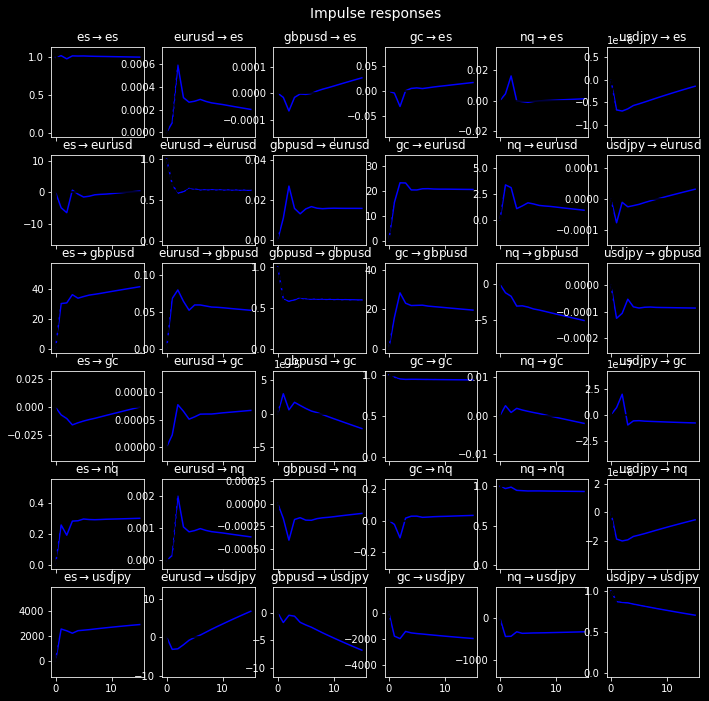

In [24]:
# Impulse-response plot
from statsmodels.tsa.vector_ar import irf
irf = vecm_fit.irf(15)
irf.plot(orth = False)
plt.show()

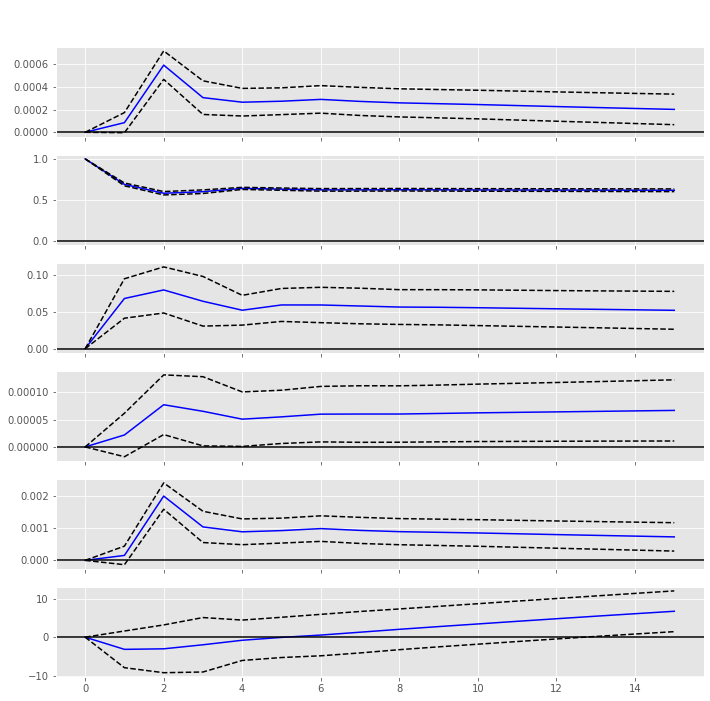

In [25]:
plt.style.use('ggplot')
irf.plot(impulse='eurusd')
plt.show()

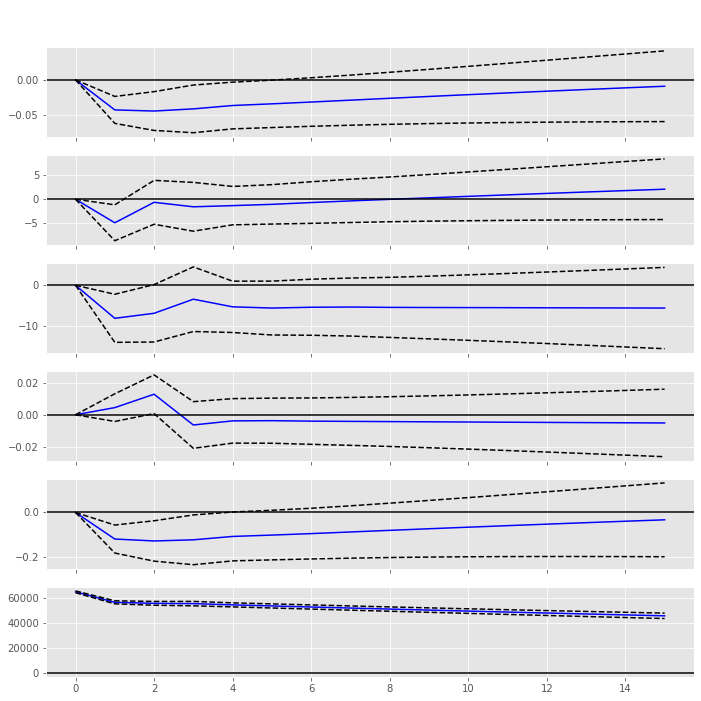

In [26]:
plt.style.use('ggplot')
irf.plot(impulse='usdjpy', orth = True)
plt.show()

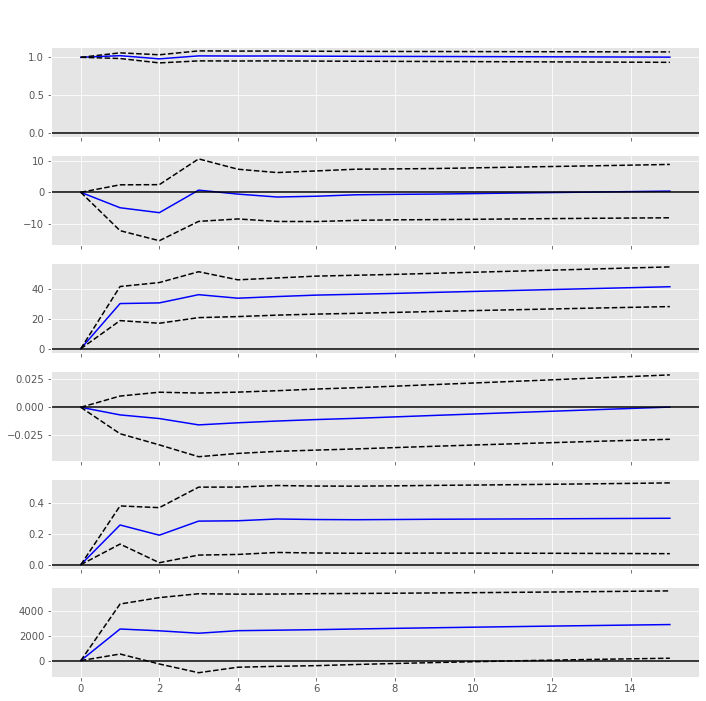

In [27]:
plt.style.use('ggplot')
irf.plot(impulse='es')
plt.show()

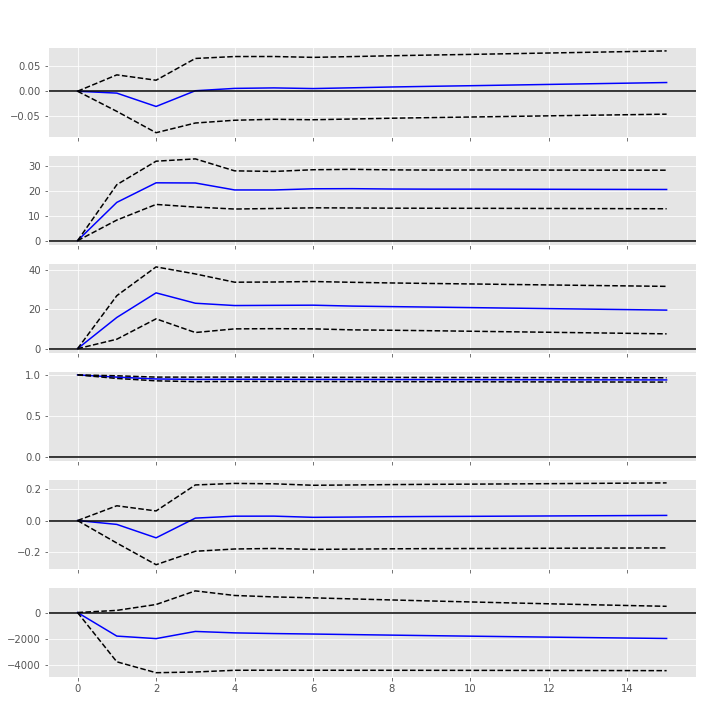

In [28]:
plt.style.use('ggplot')
irf.plot(impulse='gc')
plt.show()

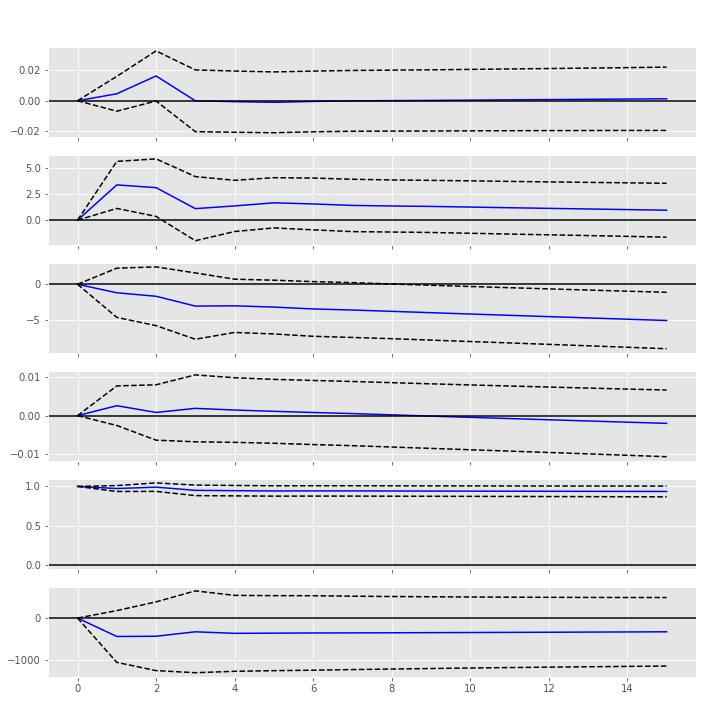

In [29]:
plt.style.use('ggplot')
irf.plot(impulse='nq')
plt.show()

In [30]:
# prediction
pd.options.display.float_format = "{:.2f}".format
forecast, lower, upper = vecm_fit.predict(nobs, 0.05)
print("lower bounds of confidence intervals:")
print(DataFrame(lower.round(2)))
print("\npoint forecasts:")
print(DataFrame(forecast.round(2)))
print("\nupper bounds of confidence intervals:")
print(DataFrame(upper.round(2)))

lower bounds of confidence intervals:
         0          1          2       3       4            5
0  2817.22 1081006.74 1211561.53 1754.12 8959.26 107147036.20
1  2816.13 1080905.78 1211440.30 1753.73 8955.87 107107152.96
2  2815.31 1080842.24 1211342.66 1753.46 8953.31 107077619.20
3  2814.59 1080781.27 1211252.25 1753.24 8951.13 107052471.30
4  2813.96 1080720.92 1211172.35 1753.05 8949.22 107030968.88
5  2813.38 1080666.47 1211100.55 1752.88 8947.49 107012107.55
6  2812.84 1080616.94 1211034.70 1752.72 8945.89 106995296.70
7  2812.34 1080570.33 1210973.82 1752.58 8944.41 106980125.00
8  2811.86 1080526.16 1210917.20 1752.45 8943.02 106966301.12
9  2811.41 1080484.32 1210864.18 1752.33 8941.70 106953616.84
10 2810.97 1080444.52 1210814.29 1752.22 8940.44 106941910.29
11 2810.56 1080406.47 1210767.15 1752.11 8939.24 106931053.23
12 2810.16 1080369.97 1210722.45 1752.01 8938.09 106920942.73
13 2809.77 1080334.89 1210679.94 1751.92 8936.98 106911494.51
14 2809.39 1080301.09 1210639.39

In [31]:
pd.options.display.float_format = "{:.2f}".format
forecast = DataFrame(forecast, index= test_ecm.index, columns= test_ecm.columns)
forecast.rename(columns = {'eurusd':'eurusd_pred', 'gbpusd':'gbpusd_pred', 'usdjpy':'usdjpy_pred',
                    'gc':'gc_pred', 'nq':'nq_pred', 'es':'es_pred'}, inplace = True)
forecast

,es_pred,eurusd_pred,gbpusd_pred,gc_pred,nq_pred,usdjpy_pred
timestamp,,,,,,
2020-05-15 15:43:00,2819.58,1081467.48,1212277.02,1755.19,8967.01,107273990.95
2020-05-15 15:44:00,2819.53,1081469.18,1212294.51,1755.22,8967.05,107275652.98
2020-05-15 15:45:00,2819.50,1081471.41,1212308.00,1755.26,8967.12,107278381.53
2020-05-15 15:46:00,2819.43,1081472.22,1212320.87,1755.30,8967.08,107280758.40
2020-05-15 15:47:00,2819.36,1081475.17,1212339.73,1755.34,8967.03,107282975.51
2020-05-15 15:48:00,2819.29,1081477.83,1212356.54,1755.38,8966.99,107285148.06
2020-05-15 15:49:00,2819.23,1081480.37,1212372.87,1755.42,8966.95,107287269.04
2020-05-15 15:50:00,2819.16,1081482.84,1212389.28,1755.46,8966.91,107289334.34
2020-05-15 15:51:00,2819.10,1081485.36,1212405.73,1755.50,8966.87,107291340.79


In [32]:
combine = concat([test_ecm, forecast], axis=1)
pred = combine[['eurusd', 'eurusd_pred', 'gbpusd', 'gbpusd_pred', 'usdjpy', 
                   'usdjpy_pred', 'gc', 'gc_pred', 'nq', 'nq_pred', 'es', 'es_pred']]
def highlight_cols(s):
    color = 'yellow'
    return 'background-color: %s' % color

pred.style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['eurusd_pred', 'gbpusd_pred', 'usdjpy_pred',
                                                               'gc_pred', 'nq_pred', 'es_pred']])

,eurusd,eurusd_pred,gbpusd,gbpusd_pred,usdjpy,usdjpy_pred,gc,gc_pred,nq,nq_pred,es,es_pred
timestamp,,,,,,,,,,,,
2020-05-15 15:43:00,1081535.000000,1081467.484800,1212550.000000,1212277.019392,107262500.000000,107273990.953982,1755.150000,1755.186882,8971.750000,8967.007531,2821.125000,2819.579301
2020-05-15 15:44:00,1081330.000000,1081469.177896,1212365.000000,1212294.513633,107273500.000000,107275652.979590,1754.950000,1755.218273,8979.500000,8967.045931,2822.875000,2819.532443
2020-05-15 15:45:00,1081385.000000,1081471.413730,1212360.000000,1212307.995240,107280000.000000,107278381.532590,1754.600000,1755.255400,8975.750000,8967.115410,2821.625000,2819.495592
2020-05-15 15:46:00,1081410.000000,1081472.219923,1212405.000000,1212320.866232,107286500.000000,107280758.400360,1755.350000,1755.298074,8972.750000,8967.075434,2820.625000,2819.427805
2020-05-15 15:47:00,1081430.000000,1081475.167969,1212050.000000,1212339.729456,107287000.000000,107282975.510002,1755.350000,1755.339047,8976.875000,8967.033605,2821.625000,2819.360641
2020-05-15 15:48:00,1081435.000000,1081477.829331,1212060.000000,1212356.542102,107284000.000000,107285148.055742,1755.750000,1755.379744,8974.500000,8966.988759,2821.125000,2819.293118
2020-05-15 15:49:00,1081435.000000,1081480.374204,1212060.000000,1212372.873386,107291500.000000,107287269.043890,1755.650000,1755.420356,8973.000000,8966.949772,2821.125000,2819.227680
2020-05-15 15:50:00,1081605.000000,1081482.835622,1212005.000000,1212389.279825,107291000.000000,107289334.342969,1755.750000,1755.460885,8982.250000,8966.911341,2824.375000,2819.162578
2020-05-15 15:51:00,1081585.000000,1081485.359403,1212090.000000,1212405.727975,107285000.000000,107291340.794906,1755.300000,1755.501160,8977.250000,8966.873239,2822.875000,2819.097880


In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# score eur_usd
mae = mean_absolute_error(pred.eurusd, pred['eurusd_pred'])
mse = mean_squared_error(pred.eurusd, pred.eurusd_pred)
rmse = np.sqrt(mse)
sum = DataFrame(index = ['Mean Absolute Error', 'Mean squared error', 'Root mean squared error'])
sum['Accuracy metrics :    EURUSD'] = [mae, mse, rmse]

# score gbp_usd
mae = mean_absolute_error(pred.gbpusd, pred['gbpusd_pred'])
mse = mean_squared_error(pred.gbpusd, pred.gbpusd_pred)
rmse = np.sqrt(mse)
sum['GBPUSD'] = [mae, mse, rmse]

# score usd_jpy
mae = mean_absolute_error(pred.usdjpy, pred['usdjpy_pred'])
mse = mean_squared_error(pred.usdjpy, pred.usdjpy_pred)
rmse = np.sqrt(mse)
sum['USDJPY'] = [mae, mse, rmse]

# score nq
mae = mean_absolute_error(pred.nq, pred['nq_pred'])
mse = mean_squared_error(pred.nq, pred.nq_pred)
rmse = np.sqrt(mse)
sum['NQ'] = [mae, mse, rmse]

# score usd_jpy
mae = mean_absolute_error(pred.es, pred['es_pred'])
mse = mean_squared_error(pred.es, pred.es_pred)
rmse = np.sqrt(mse)
sum['ES'] = [mae, mse, rmse]

# score usd_jpy
mae = mean_absolute_error(pred.gc, pred['gc_pred'])
mse = mean_squared_error(pred.gc, pred.gc_pred)
rmse = np.sqrt(mse)
sum['GC'] = [mae, mse, rmse]
sum

,Accuracy metrics : EURUSD,GBPUSD,USDJPY,NQ,ES,GC
Mean Absolute Error,165.78,341.36,10439.62,11.84,3.83,0.38
Mean squared error,60524.42,161320.03,247956660.50,182.65,20.76,0.30
Root mean squared error,246.02,401.65,15746.64,13.51,4.56,0.55
